# After sales text clustering using Transformers
## Sentence Transformers - BERT embeddings

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer

import os

pd.options.mode.chained_assignment = None

data_version = "2024-05-14"
data_base_path = "../DATA/processed"

In [2]:
# Preprocess text
def preprocess_text(text, words_to_remove=None):
    if words_to_remove is None:
        words_to_remove = []

    text = text.lower()
    words = text.split()
    text = [word for word in words if word not in words_to_remove]
    return " ".join(text)


# Load data
data_path = os.path.join(data_base_path, f"{data_version}", "text_to_analyse_clean.csv")
text_to_analyse = pd.read_csv(data_path, sep="¬", engine="python")

words_to_remove = [
    "averia",
    "averías",
    "avería",
    "defecto",
    "defectos",
    "error",
    "errores",
    "fallo",
    "fallos",
    "falla",
    "motivo",
    "motivos",
    "proble",
    "problema",
    "problemas",
]

text_to_analyse["processed_text"] = text_to_analyse["text_to_analyse"].apply(
    preprocess_text
)

In [3]:
text_to_analyse.head()

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,DESCART,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4,processed_text
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,Central de alarmas técnicas multifunción,3.0,265.0,94.0,NaN,AT HOME,AT HOME,MODULOS DE CONTROL,NaN,indican exclusivamente que se ha estropeado la...
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,Termostato Tacto superficie radio (AZA) - Blanco,1.0,251.0,91.0,4.0,SISTEMAS DE ZONAS,ACUAZONE (DI6),TERMOSTATOS,TACTO,azatactorsb se ha quedado bloqueado. no permit...
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,Módulo de control de 2 persianas con pulsador,3.0,265.0,94.0,NaN,AT HOME,AT HOME,MODULOS DE CONTROL,NaN,desde pulsadores no se puede subir la persiana...
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,Rejilla Inteligente doble Airzone motorizada 4...,1.0,264.0,31.0,92.0,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RINT,"rejilla motorizada defectuosa, sustituir rafae..."
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,Módulo de zona fancoil cableado Airzone (AZA),1.0,251.0,95.0,NaN,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE ZONA,NaN,modulo de fancoil da problemas las comunicacio...


In [4]:
# Load model
model = SentenceTransformer("all-mpnet-base-v2")

# Compute embeddings
embeddings = model.encode(text_to_analyse["processed_text"].tolist())
text_to_analyse["embeddings"] = embeddings.tolist()

C:\Users\voliveira\OneDrive - Corporacion Empresarial Altra SL\00-Proyectos\myzone\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\voliveira\OneDrive - Corporacion Empresarial Altra SL\00-Proyectos\myzone\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Load Errors
errors = pd.read_csv("../DATA/TablaTipoErrorPostventa.csv", sep=";", header=0)[
    ["Código", "CODCAR3", "CODCAR2", "DESCFAM", "Motivo General", "DESCRIPCION"]
]
errors.columns = [
    "ID_ERROR",
    "CODCAR3",
    "CODCAR2",
    "DESCFAM",
    "MOTIVO",
    "DESCRIPCION",
]  # Rename columns
errors["DESCRIPCION_DETAILED"] = errors[
    "MOTIVO"
]  # + ' ' + errors['DESCRIPCION'].fillna('') # Concatenate MOTIVO and DESCRIPCION
errors["CODCAR2"] = errors["CODCAR2"].str.replace("-", "0").astype(int)  # Clean CODCAR2

In [6]:
# Calculate embeddings for errors
errors["description_processed"] = errors["DESCRIPCION_DETAILED"].apply(preprocess_text)
errors_embeddings = model.encode(errors["description_processed"].tolist())
errors["embeddings"] = errors_embeddings.tolist()

In [7]:
# Calculate similarity
from sklearn.metrics.pairwise import cosine_similarity


def calculate_similarity(embeddings, error_embeddings):
    return cosine_similarity([embeddings], [error_embeddings])[0][0]

In [8]:
# Calculate the cosine similarity between the text_to_analyse and the errors
for index, row in errors.iterrows():
    # Create a condition for filtering
    condition = text_to_analyse["CAR3"] == row["CODCAR3"]
    if row["CODCAR2"]:
        condition &= text_to_analyse["CAR2"] == row["CODCAR2"]

    if not text_to_analyse.loc[condition, "embeddings"].empty:
        text_to_analyse.loc[condition, f'cosine_similarity_{row["ID_ERROR"]}'] = (
            text_to_analyse.loc[condition, "embeddings"].apply(
                lambda x: calculate_similarity(x, row["embeddings"])
            )
        )

    print(f"Error {row['ID_ERROR']} calculated")

Error 3.01 calculated
Error 3.02 calculated
Error 3.03 calculated
Error 3.04 calculated
Error 3.05 calculated
Error 3.08 calculated
Error 3.09 calculated
Error 3.21 calculated
Error 3.22 calculated
Error 3.23 calculated
Error 3.24 calculated
Error 3.28 calculated
Error 3.29 calculated
Error 3.41 calculated
Error 3.42 calculated
Error 3.43 calculated
Error 3.44 calculated
Error 3.45 calculated
Error 3.48 calculated
Error 3.49 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62

In [9]:
text_to_analyse.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.21,cosine_similarity_4.29,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69
17397,BG5IY2ATC4,55804.0,Problema de comunicación de cara azul AZRA6BLU...,cara azul blanca,Problema de comunicación,AZRA6BLUEFACECB,Problema de comunicación de cara azul AZRA6BLU...,AZRA6BLUEFACECB,100.0,AZRA6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18787,BGXOY2IC54,60702.0,1 x AZDI6BLUEFACECB Pantalla táctil para termo...,"Pantalla táctil para termostato, blanco.. no r...",AZDI6BLUEFACECB Pantalla táctil para termostat...,AZDI6BLUEFACECB,1 x AZDI6BLUEFACECB Pantalla táctil para termo...,AZDI6BLUEFACECB,100.0,AZDI6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3962,YMOAB5LJ3E,11745.0,El control remoto defectuoso aún está en garantía,Mando a distancia principal con cable de antig...,El control remoto muestra deriva de la sonda,TMXPLUSTBR,El control remoto defectuoso aún está en garan...,TMXPLUSTBR,100.0,TMXPLUSTBR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15092,ZMLRAW1XF9,47734.0,Termostato Blueface blanco con pantalla pixelada,NaN,Pantalla pixelada,AZCE6BLUEFACECB,Termostato Blueface blanco con pantalla pixela...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1237,CWDPBPXP25,3825.0,"Los termostatos fallan, incluso después de cad...",TERMOSTATO IBPRO6 MONOCROMO AIRZONE THINK FILAIRE,"Los termostatos fallan, incluso después de rei...",AZCE6THINKCB,"Los termostatos fallan, incluso después de cad...",AZCE6THINKCB,100.0,AZCE6THINKCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11430,K2XWMXBO9C,36432.0,TERMOSTATO NO FUNCIONA,TERMOSTATO ACUAZONE RADIO,SOLICITAMOS EL CAMBIO,AZDI6THINKRB,TERMOSTATO NO FUNCIONA TERMOSTATO ACUAZONE RAD...,AZDI6THINKRB,100.0,AZDI6THINKRB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15592,AMTSBWZQ51,49294.0,Unidad de control AZX6CCP (ns: 000C3FEW)\r\nAc...,Unidad de control AZX6CCP,Unidad de control AZX6CCP (ns: 000C3FEW)\r\nAc...,AZX6CCP,Unidad de control AZX6CCP (ns: 000C3FEW)\r\nAc...,AZX6CCP,100.0,AZX6CCP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19657,A21PZ2SY43,64200.0,HABÍA UN BOLETO ABIERTO EN 76554 APARENTE LA P...,ZONA AÉREA ZONA FÁCIL,EL NÚMERO DE BILLETE ES 76554 APARENTE ES NECE...,AZEZ6TOSBS03M5,HABÍA UN BOLETO ABIERTO EN 76554 APARENTE LA P...,AZEZ6TOSBS03M5,100.0,AZEZ6TOSBS03M5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21658,MZGYNZ5J4A,73061.0,NO FUNCIONA.,HUB DE SERVIDOR WEB AIRZONE NUBE DUAL,NO FUNCIONA,AZX6WSPHUB,NO FUNCIONA. HUB DE SERVIDOR WEB AIRZONE NUBE ...,AZX6WSPHUB,100.0,AZX6WSPHUB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18448,Y2PGYGKT59,59505.0,"El equipo se enciende pero se queda con la \""A...",AZUL CERO,"ERROR SE SOFTWARE, SE RUEGA SUSTITUCIÓN DEL EQ...",AZDI6BLUEZEROCB,"El equipo se enciende pero se queda con la \""A...",AZDI6BLUEZEROCB,100.0,AZDI6BLUEZEROCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
cosine_columns = [col for col in text_to_analyse.columns if "cosine_similarity_" in col]
text_to_analyse[cosine_columns] = text_to_analyse[cosine_columns].fillna(
    0
)  # Fill NA with 0
text_to_analyse.loc[:, "highest_score"] = text_to_analyse[cosine_columns].max(axis=1)
text_to_analyse.loc[:, "highest_score_error"] = (
    text_to_analyse[cosine_columns].idxmax(axis=1).apply(lambda x: x.split("_")[-1])
)

In [11]:
errors["ID_ERROR"] = errors["ID_ERROR"].astype(str)
text_to_analyse = text_to_analyse.merge(
    errors[["ID_ERROR", "MOTIVO"]],
    left_on="highest_score_error",
    right_on="ID_ERROR",
    how="left",
)

In [12]:
text_to_analyse.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69,highest_score,highest_score_error,ID_ERROR,MOTIVO
21095,KMRXLW1P56,36303.0,MOTORES DE REJILLAS AVERIADOS,2 REJILLAS INT. TRIPLE 400*150 BL,MOTOR AVERIADO,RINT040015BKMRE,MOTORES DE REJILLAS AVERIADOS 2 REJILLAS INT. ...,RINT040015BKMRE,100.0,RINT040015BKMRE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.572155,4.04,4.04,Ruido del motor
18098,L2TQMMDT60,31191.0,Fallan 2ud de TERMOSTATO MONOCROMO THINK 32Z C...,NaN,EL TERMOSTATO FALLA Y SE SOLICITA CAMBIARLO PO...,AZDI6THINKC,Fallan 2ud de TERMOSTATO MONOCROMO THINK 32Z C...,AZDI6THINKCB,96.0,AZDI6THINKCB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.500745,3.01,3.01,Termostato bloqueado
14801,ZMLPAWHV5D,24391.0,VARIOS,PASARELA MITSUBISHI,TRAE LOS CABLES MAL DE FABRICA ¿?,AZX6QADAPTMEL,VARIOS PASARELA MITSUBISHI TRAE LOS CABLES MAL...,AZX6QADAPTMEL,100.0,AZX6QADAPTMEL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.388684,3.44,3.44,Unidad no arranca
6817,Y2CDB5HLA2,10781.0,Visto con Mehdi Harrak el puerto domótico de d...,Placa central del sistema Innobus Pro6 (CE6),puerto domitico,AZCE6IBPRO6,Visto con Mehdi Harrak el puerto domótico de d...,AZCE6IBPRO6,100.0,AZCE6IBPRO6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.364659,3.81,3.81,Central bloqueada o no alimenta
31964,ZWZKZ2GX68,56347.0,NO FUNCIONA,TERMOSTATO LITE RADIO BLANCO,NO ENCIENDE,AZCE6LITERB,NO FUNCIONA TERMOSTATO LITE RADIO BLANCO NO EN...,AZCE6LITERB,100.0,AZCE6LITERB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.517922,3.04,3.04,No funciona el táctil
37885,MJMYNZ1J2F,68194.0,"CENTRAL EN GARANTIA, NO SE LO QUE LE PASA.",FLEXA3 CENTRAL,"CENTRAL EN GARANTIA, NO SE LO QUE LE PASA.",AZCE6FLEXA3,"CENTRAL EN GARANTIA, NO SE LO QUE LE PASA. FLE...",AZCE6FLEXA3,100.0,AZCE6FLEXA3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.561578,3.81,3.81,Central bloqueada o no alimenta
27063,AGXOBWDQAB,46795.0,TERMOSTATO BLUEFACE NO FUNCIONA,OTT. CABLE BLUEFACE BL8,NO FUNCIONA,AZCE6BLUEFACECB,TERMOSTATO BLUEFACE NO FUNCIONA OTT. CABLE BLU...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.463969,3.01,3.01,Termostato bloqueado
46626,L2HXBGXIF6,89091.0,"Buenos dias,\r\nNuestro cliente ETNAIR 54 nos ...",Radio TH,Termostato bloqueado / \'\' Manchado \'\',AZCE6THINKRB,"Buenos dias,\r\nNuestro cliente ETNAIR 54 nos ...",AZCE6THINKRB,100.0,AZCE6THINKRB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.436558,3.03,3.03,Fallo de pantalla
22807,Z2XKAGXW1F,39412.0,MATERIAL QUE NO FUNCIONA,NaN,REEMPLAZO DE INTERFAZ A AZX6QADAPT3MEL,AZX6QADAPTMEL,MATERIAL QUE NO FUNCIONA REEMPLAZO DE INTERFA...,AZX6QADAPTMEL,100.0,AZX6QADAPTMEL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.328076,3.43,3.43,Fallo de comunicaciones con la máquina
40680,LPAALJTL13,74543.0,TARJETA ELECTRÓNICA PACK PLENUM PP8PANBS08S3 H...,PACK PLENUM AIRZONE QAI MEDIANO IB8 PANASONIC,CARTA PACK PLENUM HORS SERVICE led D11,AZCE6CB1IAQE,TARJETA ELECTRÓNICA PACK PLENUM PP8PANBS08S3 H...,AZCE6CB1IAQE,100.0,AZCE6CB1IAQE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.290023,3.82,3.82,Fallo de comunicaciones cableadas


In [13]:
top10_per_error = (
    text_to_analyse[
        ["codigo", "text_to_analyse", "highest_score", "highest_score_error"]
    ]
    .groupby("highest_score_error", group_keys=False)
    .apply(lambda x: x.nlargest(10, "highest_score"))
    .reset_index(drop=True)
)

top10_per_error.head(500)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_11680\3879973192.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  text_to_analyse[


,codigo,text_to_analyse,highest_score,highest_score_error
0,BGRPY2DRA7,TERMOSTATO BLOQUEADO TERMOSTATO ESTA BLOQUEADO...,0.873891,3.01
1,CW1LAP5IED,TERMOSTATO BLOQUEADO TERMOSTATO THINKC BLANCO ...,0.847682,3.01
2,N2LTAGVMBD,TERMOSTATO BLOQUEADO TERMOSTATO PENSAR El mand...,0.804312,3.01
3,NGIXMPVOD4,"Termostato bloqueado, imposible cambiar de mod...",0.796784,3.01
4,MWDVAMTL6E,LOS TERMOSTATOS SE QUEDAN BLOQUEADOS TERMOSTAT...,0.790993,3.01
...,...,...,...,...
409,B2LRZWLX04,"La sonda ambiente no funciona, no manda temper...",0.240174,4.63
410,MWQDMZTU95,2 RECEPTORES AVERIADOS SENSOR DE TEMPERATURA E...,0.231570,4.63
411,ZMTMZ2KT54,"N°48315 Cable BUS 2x0,5+2x0,22 - 15M N°48315\r...",0.217293,4.63
412,MPGVL5HMAF,N°83681 BYPASS CIRCULAR DN150 PARA PLENUM N°83...,0.214375,4.63


In [14]:
text_to_analyse[text_to_analyse["codigo"] == "MMHSNG1V2C"][
    ["codigo", "text_to_analyse", "highest_score", "highest_score_error"]
]

,codigo,text_to_analyse,highest_score,highest_score_error
20651,MMHSNG1V2C,WEBSERVER QUE HA ESTADO FUNCIONANDO DURANTE TR...,0.507571,3.23


In [15]:
"""import csv
top50_per_error = text_to_analyse[['codigo','text_to_analyse', 'highest_score', 'highest_score_error']] \
    .groupby('highest_score_error', group_keys=False) \
    .apply(lambda x: x.nlargest(50, 'highest_score')) \
    .reset_index(drop=True)

top50_per_error.to_csv("../DATA/processed/2024-05-14/top50_per_error.csv", index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)"""

In [13]:
import csv
top500_per_error = text_to_analyse[['codigo','text_to_analyse', 'highest_score', 'highest_score_error']] \
    .groupby('highest_score_error', group_keys=False) \
    .apply(lambda x: x.nlargest(500, 'highest_score')) \
    .reset_index(drop=True)

top500_per_error.to_csv("../DATA/processed/2024-05-14/top500_per_error.csv", index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)

# Visualize the results

In [24]:
text_to_analyse["embeddings"].to_numpy()

array([list([-0.036241572350263596, -0.06483298540115356, -0.026371410116553307, -0.0018989471718668938, 0.005460276734083891, 0.03526464104652405, -0.0032089196611195803, 0.0271702129393816, 0.028763871639966965, 0.007633000146597624, 0.0049254740588366985, 0.07033972442150116, -0.007547736167907715, -0.027323944494128227, -0.04236820712685585, 0.052958860993385315, -0.01051160879433155, 0.02627137489616871, -0.045401155948638916, -0.03528283163905144, -0.024204911664128304, 0.01660298928618431, 0.0030672226566821337, 0.010111445561051369, -0.012042517773807049, -0.029081087559461594, 0.03195194527506828, -0.04179424047470093, 0.02219092659652233, -0.052887868136167526, 0.06355708837509155, 0.05281463637948036, -0.011813521385192871, -0.003756929887458682, 2.334816144866636e-06, 0.017439892515540123, -0.033183176070451736, -0.024463428184390068, 0.024471554905176163, -0.012573686428368092, -0.04039512574672699, -0.06333605200052261, 0.00283682974986732, 0.0029216608963906765, -0.03037

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0        3.84
1        3.84
2        3.84
3        3.84
4        3.05
         ... 
47799    3.01
47800    3.28
47801    3.01
47802    3.44
47803    3.01
Name: highest_score_error, Length: 47804, dtype: object

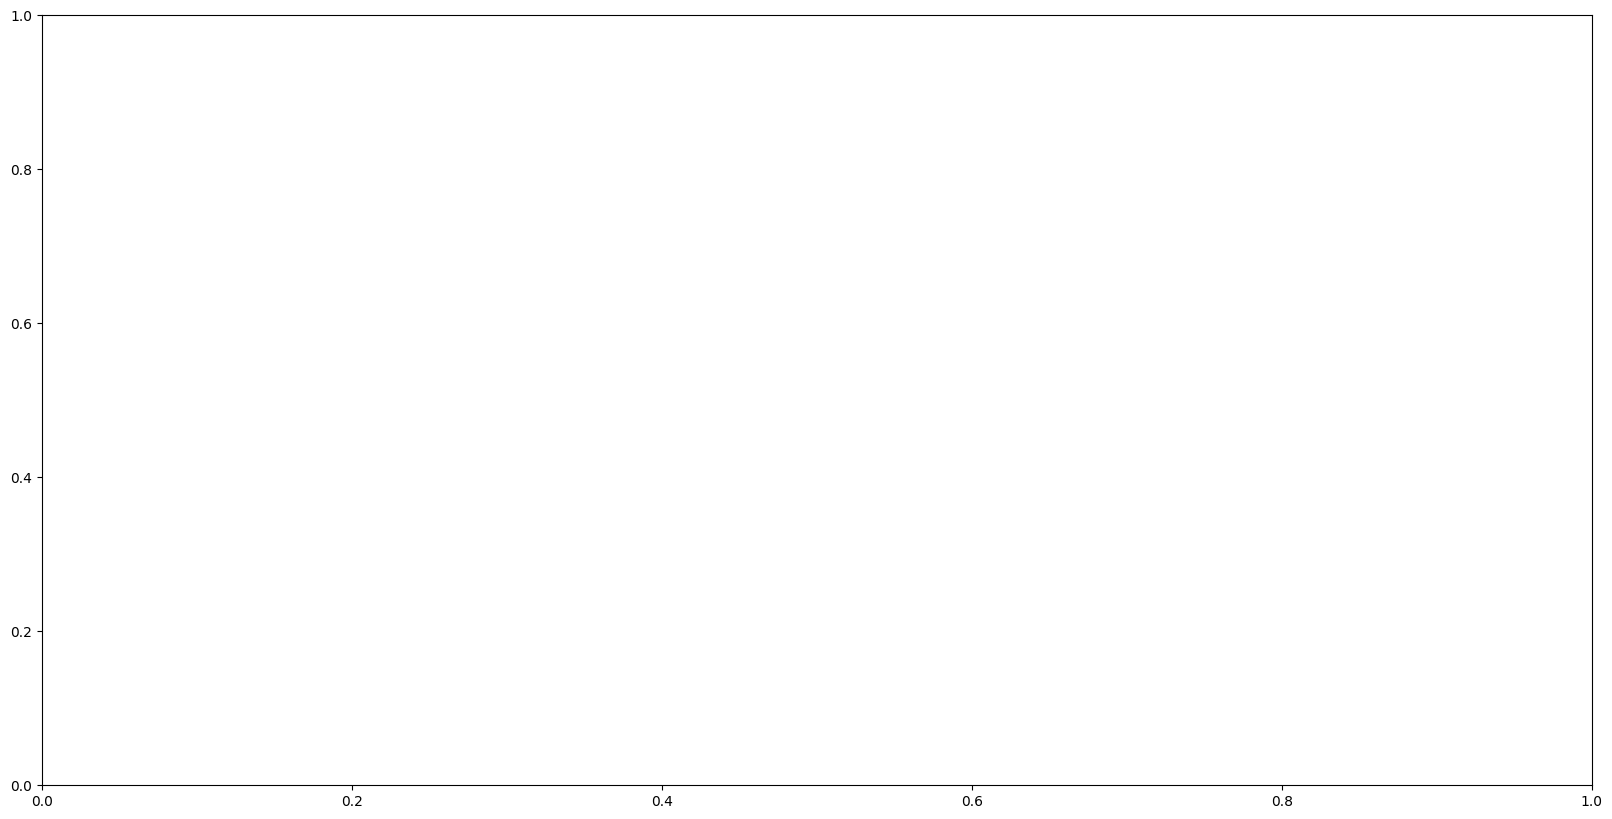

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'embeddings' column to a NumPy array
embeddings = np.stack(text_to_analyse["embeddings"].to_numpy())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embeddings)

In [34]:
# Plot the results
from sklearn.preprocessing import LabelEncoder

# Ensure 'highest_score_error' is numeric
#text_to_analyse['highest_score_error'] = text_to_analyse['highest_score_error'].astype(str)
#text_to_analyse['highest_score_error_color'] = LabelEncoder().fit_transform(text_to_analyse['highest_score_error'])
text_to_analyse['highest_score_error_color'] = pd.to_numeric(text_to_analyse["highest_score_error"], errors="coerce")

plt.figure(figsize=(20, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=text_to_analyse['highest_score_error_color'], cmap="tab20")
plt.colorbar()
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

In [30]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(embeddings)
X_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2", "TSNE3"])

In [35]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    X_tsne["TSNE1"],
    X_tsne["TSNE2"],
    X_tsne["TSNE3"],
    c=text_to_analyse['highest_score_error_color'],
    cmap="viridis",
)
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
# Add legend
plt.legend(*scatter.legend_elements(num=10), title="Classes")
plt.title("Sentence Transformers - Embeddings")
plt.show()

# Save results in Qdrant database

In [16]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
from qdrant_client.http.models import Filter, FieldCondition, MatchValue

qdrant_client = QdrantClient(":memory:")

qdrant_client.create_collection(
    collection_name="MyZone-DefectClassification",
    vectors_config=qmodels.VectorParams(size=768, distance=qmodels.Distance.COSINE),
)

In [17]:
# Insert vectors into Qdrant
points = [
    qmodels.PointStruct(
        id=id,
        vector=row["embeddings"],
        payload={
            "error": row["highest_score_error"],
            "codigo": row["codigo"],
            "error_description": row["MOTIVO"],
            "text": row["text_to_analyse"],
            "family": row["CAR3"],
            "sistema": row["CAR2"],
        },
    )
    for id, row in text_to_analyse.iterrows()
]

qdrant_client.upsert(collection_name="MyZone-DefectClassification", points=points)

In [18]:
# Define a function to search for errors
def define_error(text, family):
    query_embedding = model.encode(text).tolist()

    # Define the filter
    filter_condition = Filter(
        must=[FieldCondition(key="family", match=MatchValue(value=int(family)))]
    )

    search_result = qdrant_client.search(
        collection_name="MyZone-DefectClassification",
        query_vector=query_embedding,
        limit=20,
        query_filter=filter_condition,
    )
    df = pd.DataFrame(
        [
            (result.payload["error_description"], result.score)
            for result in search_result
        ],
        columns=["Error", "Score"],
    )

    group = df.groupby("Error").max().sort_values(by="Score", ascending=False)

    # total = group[1].sum()
    # group['percentage'] = group[group[1] > 0.2][1].apply(lambda x: x/total)

    return group["Score"].to_dict()

In [19]:
define_error("Fallo de la pantalla", "91")

In [20]:
import gradio as gr

# Create the Gradio interface
iface = gr.Interface(
    fn=define_error,
    inputs=[
        gr.Textbox(
            lines=1,
            placeholder="Enter error description here",
            label="Error Description",
            value="Fallo de la pantalla",
        ),
        gr.Textbox(
            lines=1, placeholder="Product Family", label="Product Family", value="91"
        ),
    ],
    outputs=gr.Label(num_top_classes=5),
    title="Error probability calculator",
    description="Enter error description and the product family to get the most probable error.",
)

# Launch the interface
iface.launch()

## Evaluate the model

In [21]:
# Separate the data into train and test
test_dataset_ids = pd.read_csv("../DATA/processed/test_dataset_ids.csv")
test_dataset = text_to_analyse[
    text_to_analyse["codigo"].isin(test_dataset_ids["codigo"])
]

In [22]:
test_dataset = test_dataset.merge(test_dataset_ids, on="codigo", how="inner")
test_dataset["ERROR_POSTVENTA"] = test_dataset["ERROR_POSTVENTA"].astype(str)
test_dataset["highest_score_error"] = test_dataset["highest_score_error"].astype(str)

In [26]:
test_dataset[["highest_score_error", "ERROR_POSTVENTA"]]

In [24]:
from sklearn.metrics import classification_report

print(
    classification_report(
        test_dataset["ERROR_POSTVENTA"], test_dataset["highest_score_error"]
    )
)

In [25]:
test_dataset.count()